<p style="text-align:left; font-size:90%">
    BUSA90501 Machine Learning
    <span style="float:right;">© 2022 University of Melbourne (excluding links to external images)</span>
</p>

# Workshop 1: Evaluation and Naive Bayes
***
In this worksheet we cover:
* [evaluation](#Evaluation)
* [cross-validation](#Cross-validation)
* [Naive Bayes classifiers](#Naive-Bayes-classifiers)

Below we import the packages we need for the coding questions..

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io

***
## Evaluation
Evaluation is an important part of the machine learning workflow. Before deploying a machine learning model, it's essential to understand how it performs.

### Sampling for evaluation
It would be wrong to evaluate a model using data that has already been used for training. Doing so would lead to a _biased_ (often optimistic) estimate of the performance, as the model may have overfit the training data. To obtain an _unbiased_ estimate of the performance, we should use labelled data that's _independent_ of the training data. This allows us to assess whether the model generalises to new (but representative) data outside the training data.

There are two practical evaluation methods:
* **Holdout method:** a random subset of the labelled data set is reserved for evaluation. This is often called a test set or holdout set.
* **Cross-validation:** evaluation is repeated multiple times for different random splits into train/test sets. There are a few variants:
 * **Random sub-sampling:** each train/test split is drawn with replacement from the original data set.
 * **k-fold cross-validation:** the original data set is partitioned into $k$ folds and the model is evaluated over $k$ rounds. In each round one fold is used as the test set (the remaining folds are used for training).
 * **Leave-one-out cross-validation:** the model is evaluated over $n$ rounds (where $n$ is the number of instances in the data set). In each round, one instance is "left out" (used for testing) and the remaining instances are used for training. 

We'll cover cross-validation in more detail shortly.

<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 1 (Discussion)
Suppose Alice takes a labelled dataset $D$ with 100 instances and 1000 features. She computes the correlation of each feature with the class label and discards 950 features with the lowest correlation. She now has a processed version $D'$ of the dataset (with only 50 features). She splits $D'$ into a train/test set with an 70:30 split. She fits a linear regression model on the training set and evaluates the model accuracy on the test set. She reports the accuracy as 90\%. Why might this estimate of 90\% accuracy be overly optimistic? Give reasons.
</blockquote>

### Evaluation measures for binary classification
A binary classifier is evaluated on a test set by comparing the classifier's predictions to the ground truth. For each test instance, there are only four possibilities:
* true positive: instance is **predicted positive** and **truth is positive**
* true negative: instance is **predicted negative** and **truth is negative**
* false positive: instance is **predicted positive** but **truth is negative**
* false negative: instance is **predicted negative** but **truth is positive**

Errors are only made in the last two cases. We often count the number of true positives, true negatives, etc. and represent the counts in a table called a _confusion matrix_.

<img src="confusion-matrix.png"  style="width:300px;">

Evaluation measures distill information from the confusion matrix into a single number (often between 0 and 1). Some examples are listed below.
$$
\begin{align}
\text{Error rate}  &= \frac{\mathrm{FP} + \mathrm{FN}}{\mathrm{TP} + \mathrm{TN} + \mathrm{FP} + \mathrm{FN}} \\
\mathrm{Accuracy}  &= \frac{\mathrm{TP} + \mathrm{TN}}{\mathrm{TP} + \mathrm{TN} + \mathrm{FP} + \mathrm{FN}} \\
\mathrm{Precision} &= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} \\
\mathrm{Recall}    &= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}} \\
\text{F1-score}    &= 2 \times \frac{\mathrm{Precision} \times \mathrm{Recall}}{\mathrm{Precision} + \mathrm{Recall}}
\end{align}
$$

<blockquote style="padding: 10px; background-color: #fef5e7;">

#### Question 2 (Pen/paper)
Consider the task of building a classifier from random data, where the attribute values are generated randomly irrespective of the class labels. Assume the data set contains instances from two classes, $+$ and $-$. Half of the data set is used for training and the remaining half is used for testing.

1. Suppose there are an equal number of $+$ and $-$ instances in the data. Consider a classifier that predicts $+$ for all test instances. What is the expected error rate of the classifier on the test data?

1. Repeat the previous analysis assuming that the classifier predicts $+$ with probability 0.8 and $-$ with probability 0.2 (for any given test record).

1. Suppose two-thirds of the data belongs to the $+$ class and the remaining one-third belongs to the $-$ class. What is the expected error of a classifier that predicts $+$ for every test instance?

1. Repeat the previous analysis assuming that the classifier predicts predicts $+$ with probability $\frac{2}{3}$ and $-$ with probability $\frac{1}{3}$ (for any given test instance).
</blockquote>

### Receiver operating characteristic curve

<img src="https://upload.wikimedia.org/wikipedia/commons/3/36/Roc-draft-xkcd-style.svg">

The receiver operating characteristic (ROC) curve illustrates the performance of a binary classifier as its threshold is varied. It shows the trade-off between the two types of errors that can be made: false positives and false negatives. The _true positive rate_
$$
\mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}} = \mathrm{Recall} = \mathrm{Sensitivity}
$$
is plotted on the $y$-axis and the _false positive rate_
$$
\mathrm{FPR} = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}} = \text{Fall-out} = 1 - \mathrm{Specificity}
$$
is plotted on the $x$-axis.

**Example:** Suppose a classifier is used to identify people with a disease. Ideally the classifier should have a high TPR and a low FPR. It has a high TPR if it does a good job at detecting people with the disease (few false negatives). It has a low FPR if it rarely predicts healthy people are diseased (few false positives).

<blockquote style="padding: 10px; background-color: #fef5e7;">

#### Question 3 (Pen/paper)
You are asked to evaluate the performance of two classification models, $M_1$ and $M_2$. The test set you are given contains 26 binary attributes labeled "A" through "Z". The table below shows the posterior probabilities obtained by applying the models to the test set. (Only the posterior probabilities for the positive class are shown). As this is a two-class problem, $P(-) = 1 - P(+)$ and $P(-|A,\ldots,Z) = 1 - P(+|A,\ldots,Z)$. Assume that we are mostly interested in detecting instances from the positive class.

Instance | True Class | $P(+|A,\ldots,Z,M_1)$ | $P(+|A,\ldots,Z,M_2)$
--- | --- | --- | ---
1  | $+$ | 0.73 | 0.61
2  | $+$ | 0.69 | 0.03
3  | $-$ | 0.44 | 0.68
4  | $-$ | 0.55 | 0.31
5  | $+$ | 0.67 | 0.45
6  | $+$ | 0.47 | 0.09
7  | $-$ | 0.08 | 0.38
8  | $-$ | 0.15 | 0.05
9  | $+$ | 0.45 | 0.01
10 | $-$ | 0.35 | 0.04

1. Plot the ROC curve for both $M_1$ and $M_2$ (You should plot them on the same graph.) Compute the AUC for $M_1$.  Compute the AUC for $M_2$. Which model do you think is better? Explain your reasons.

1. For model $M_1$, suppose you choose the cutoff threshold to be $t = 0.5$. In other words, any test instances whose posterior probability is greater than $t$ will be classified as a positive example. Compute the precision, recall, and F-measure for the model at this threshold value.

1. Repeat the analysis for part (b) using the same cutoff threshold on model $M_2$. Compare the F-measure results for both models. Which model is better? Are the results consistent with what you expect from the ROC curve?
</blockquote>

<blockquote style="padding: 10px; background-color: #eafaf1;">

#### Question 4 (Coding)
Repeat the question above in Python. For your convenience, the code block below loads the data from the table into three NumPy arrays: 
* `y` true class labels, 
* `scores_1` $P(+|A,\ldots,Z,M_1)$
* `scores_2` $P(+|A,\ldots,Z,M_2)$

Useful scikit-learn functions are 
* `sklearn.metrics.roc_curve`
* `sklearn.metrics.auc`.
* `sklearn.metrics.precision_score`
* `sklearn.metrics.recall_score`
* `sklearn.metrics.f1_score`
</blockquote>

In [5]:
# Read table data into NumPy arrays
table_str = """
id | y | scores_1 | scores_2
1  | $+$ | 0.73 | 0.61
2  | $+$ | 0.69 | 0.03
3  | $-$ | 0.44 | 0.68
4  | $-$ | 0.55 | 0.31
5  | $+$ | 0.67 | 0.45
6  | $+$ | 0.47 | 0.09
7  | $-$ | 0.08 | 0.38
8  | $-$ | 0.15 | 0.05
9  | $+$ | 0.45 | 0.01
10 | $-$ | 0.35 | 0.04
"""

table_df = pd.read_csv(io.StringIO(table_str), sep="\s\|\s", engine='python')
y = table_df.y.map({'$+$': 1, '$-$': 0}).values
scores_1 = table_df.scores_1.values
scores_2 = table_df.scores_2.values

print("Labels:", y)
print("Scores from model 1:", scores_1)
print("Scores from model 2:", scores_2)

Labels: [1 1 0 0 1 1 0 0 1 0]
Scores from model 1: [0.73 0.69 0.44 0.55 0.67 0.47 0.08 0.15 0.45 0.35]
Scores from model 2: [0.61 0.03 0.68 0.31 0.45 0.09 0.38 0.05 0.01 0.04]


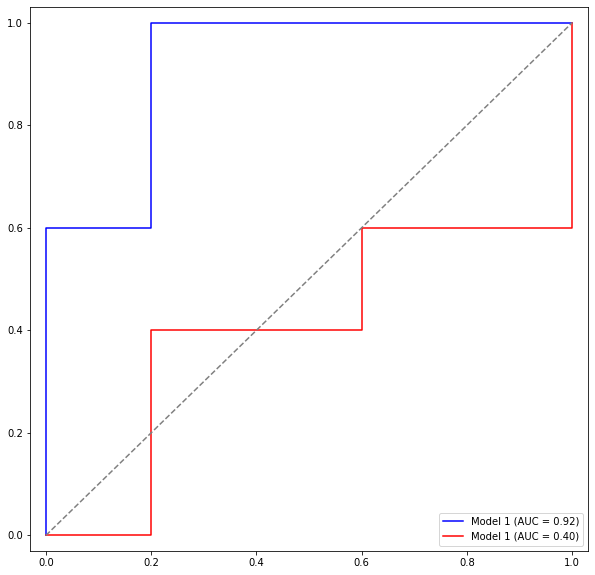

In [9]:
from sklearn.metrics import roc_curve, auc


# Use help(roc_curve) and help(auc) to check the input and output of them


# Compute the ROC curves

fpr_1, tpr_1, thresholds_1 = roc_curve(y, scores_1, pos_label=1) # ROC curve for M1
... # ROC curve for M2


# Compute the AUC

auc_1 = auc(fpr_1, tpr_1) # AUC for M1
... # AUC for M2


# Make standard ROC plot

plt.figure(figsize=(10, 10))
plt.plot(fpr_1, tpr_1, color='b', label='Model 1 (AUC = %0.2f)' % auc_1)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])


###### Fiil in#######
#Set title and label for the x and y axis
# you can use help(plt) and search "title" to find the function you need



###### Your code end here#######

plt.legend(loc='lower right')
plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Fill in
#pred_1 = np.array(scores_1 > 0.5, dtype=int)

prec_m1 = precision_score(y, pred_1)
rec_m1 = ...
f1_m1 = ...
prec_m2 = ...
rec_m2 = ...
f1_m2 = ...


print("Model 1")
print("Precision:", prec_m1)
print("Recall:", rec_m1)
print("F1:", f1_m1)

print("-------")

print("Model 2")
print("Precision:", prec_m2)
print("Recall:", rec_m2)
print("F1:", f1_m2)

[1 1 0 1 1 0 0 0 0 0]


TypeError: precision_score() missing 1 required positional argument: 'y_pred'

***
## Cross-validation
Cross-validation is an evaluation method that can be used when data is scarce. Training and evaluation are repeated multiple times for different random splits of the data into train/test sets. The final evaluation measure is taken as an average over the rounds. By repeating the evaluation over multiple rounds, the variability of the estimate is reduced.

### K-fold cross-validation
Here we focus on $k$-fold cross-validation. The key steps are as follows:
1. The data is partitioned into $k$ equal parts (folds)
1. Training and evaluation are repeated for $k$ rounds. In each round, one fold is used for testing and the remaining $k-1$ folds are used for training.
1. The evaluation measure is averaged over the $k$ rounds.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg" style="width:450px;">

### [Aside] Parameter tuning/model selection
Cross-validation can also be used to tune model parameters and/or to select the best model among some candidates. The motivation is the same as described above: we want to assess how the models generalise without using too much data. This is illustrated in the diagram below. Here we are choosing the best parameter setting among 5 different choices.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" style="width:500px;">

Let's use $k$-fold cross-validation to estimate the accuracy of a classifier on the Iris flower data set. This data set contains observations of three species of Iris flowers. There are four features for each observation: the length and width of the sepals and petals in centimetres. The goal is to predict the species based on the measurements.

In the code block below we load the data into a feature matrix `X` and label vector `y`.

In [ ]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

print("There are {} instances and {} features".format(X.shape[0], X.shape[1]))
print("There are {} classes".format(np.unique(y).size))

Let's see how cross-validation works in scikit-learn. $k$-fold cross-validation is implemented in `sklearn.model_selection.KFold`. 

We start by instantiating a KFold instance, which takes the number of splits ($k$) as an argument. You can also specify whether to randomly shuffle the data before partitioning into folds (it's safest to set this to True).

We then call the `split` method on the iris data set and carry out some operations for each round in a for-loop.
Note that the `train` and `test` arrays for each round are indices into the original data. We can access the feature vectors/labels using array indexing.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True)
for train, test in kf.split(X):
    print("-----")
    print("Items in train:", train)
    print("Items in test:", test)

Below we estimate the accuracy of a logistic regression classifier using a held-out test set.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = LogisticRegression()
clf.fit(X_train, y_train)
print("Accuracy on held-out test set:", clf.score(X_test, y_test))

<blockquote style="padding: 10px; background-color: #eafaf1;">

#### Question 5 (Coding)
Estimate the accuracy of the logistic regression classifier using 10-fold cross validation. How does this compare to the estimate obtained using the hold-out method above?
</blockquote>

In [ ]:
# Fill in

<blockquote style="padding: 10px; background-color: #ebf5fb;">

#### Question 6 (Discussion)
Later in the course we'll see that it's sometimes important to standardize the features so that they vary on roughly the same scale. A common approach is to subtract the mean and divide by the standard deviation (for each feature). If we wanted to standardize the features, does it make any difference whether this is done before or inside the cross-validation for-loop?
</blockquote>

***
## Naive Bayes classifiers
The Naive Bayes classifier is a probabilistic classifier that makes strong (naive) independence assumptions between the features. The probability distribution over the class label $y \in \{1, \ldots, C\}$ given a feature vector $\mathbf{x} = [x_1, \cdots, x_p]$ is assumed to have the following form:
$$
p(y = c| \mathbf{x}) = \frac{p(c) \prod_{i = 1}^{p} p(x_i | c)}{p(\mathbf{x})}
$$

This comes from applying Bayes' theorem and assuming $p(x_i | x_{i+1}, \ldots, x_p, c)= p(x_i | c)$ holds true for all features $i$.

When implementing a Naive Bayes classifier, one must make some assumptions about the form of the distributions. Common variants implemented in scikit-learn are:
* `GaussianNB` assumes $p(x_i|c)$ corresponds to a Gaussian distribution (continuous data)
* `MultinomialNB` assumes $p(\mathbf{x}|c)$ corresponds to a Multinomial distribution (count data)
* `BernoulliNB` assumes $p(x_i|c)$ corresponds to a Bernoulli distribution (binary data)

<blockquote style="padding: 10px; background-color: #fef5e7;">

#### Question 7 (Pen/paper)
Consider the following dataset

Instance | A | B | C | Class
--- | --- | --- | --- | ---
1  | 0 | 0 | 0 | +
2  | 0 | 0 | 1 | -
3  | 0 | 1 | 1 | -
4  | 0 | 1 | 1 | -
5  | 0 | 0 | 1 | +
6  | 1 | 0 | 1 | +
7  | 1 | 0 | 1 | -
8  | 1 | 0 | 1 | -
9  | 1 | 1 | 1 | +
10 | 1 | 0 | 1 | +

1. Estimate the conditional probabilities for $P(A|+)$, $P(B|+)$, $P(C|+)$, $P(A|-)$, $P(B|-)$, and $P(C|-)$.

2. Use the estimate of conditional probabilities given in the previous question to predict the class label for a test instance $(A = 0,B = 1,C = 0)$ using the naive Bayes approach.
</blockquote>